This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/dispersion.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/dispersion/ref/m.dat &> /dev/null

# Calculation of Magnon Dispersion

## Run Simulation

In [2]:
from magnumnp import *
import torch
import pathlib
from tqdm import tqdm

set_log_level(25) # show info_green, but hide info_blue
torch.set_default_dtype(torch.float32)
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

# initialize state
Nt = 500
dt = 1e-12

n = 500, 25, 1
dx = 2e-9, 2e-9, 1e-9

Ms = 8e5
A = 1.3e-11
alpha = 1e-8

h_bias   = [804e3, 0.0, 0.0]
h_excite = [0.0, 0.0, 400e3]

origin = (-n[0]*dx[0]/2, -n[1]*dx[1]/2, -n[2]*dx[2]/2)
mesh = Mesh(n, dx, origin)

state = State(mesh)
x,y,z = mesh.SpatialCoordinate()
mt = torch.zeros((Nt, n[0], n[1], n[2]))

state.material = {
    'Ms': Ms,
    'A': A,
    'alpha': alpha
    }

state.m = state.Constant(h_bias)
normalize(state.m)

# initialize spin wave excitation field
N = n[0] / 2
kc = N/2. * (2.*torch.pi/(n[0]*dx[0]))
fc = 1/(2*dt)

h0 = state.Constant(h_excite)
h0 *= Expression(torch.sinc(kc / torch.pi * x))
h0 *= Expression(torch.sinc(kc / torch.pi * y))

omega = 2.*fc
t0 = 50e-12
ht = lambda state: torch.sinc(omega * (state.t-t0)) * h0

# initialize field terms
demag    = DemagField()
exchange = ExchangeField()
bias     = ExternalField(h_bias)
excite   = ExternalField(ht)

# initialize LLG solver and relax state
llg = LLGSolver([demag, exchange, bias])
llg.relax(state)

# apply spin wave excitation
state.t = 0.0
llg = LLGSolver([demag, exchange, bias, excite])
logger = Logger(this_dir / "data", ['t', 'm'])

for i in tqdm(range(Nt)):
    mt[i,...] = state.m[...,2]
    llg.step(state, dt)
    logger << state

torch.save(mt, "data/mt_saved.pt")
Timer.print_report()

2025-08-20 07:56:11  magnum.np:INFO magnum.np 2.1.0 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmp9__ysjr7.json --HistoryManager.hist_file=:memory:)


2025-08-20 07:56:11  magnum.np:INFO [State] running on device: cpu (dtype = float32)


2025-08-20 07:56:11  magnum.np:INFO [Mesh] 500x25x1 (dx= 2e-09 x 2e-09 x 1e-09)


2025-08-20 07:56:11  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


2025-08-20 07:56:34  magnum.np:INFO [LLG] relax: Successfully converged (iter=2, dm_tol = 100)


2025-08-20 07:56:34  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<01:45,  4.73it/s]

  0%|          | 2/500 [00:00<01:23,  5.93it/s]

  1%|          | 3/500 [00:00<01:23,  5.94it/s]

  1%|          | 4/500 [00:00<01:21,  6.10it/s]

  1%|          | 5/500 [00:00<01:17,  6.36it/s]

  1%|          | 6/500 [00:00<01:12,  6.85it/s]

  1%|▏         | 7/500 [00:01<01:11,  6.88it/s]

  2%|▏         | 8/500 [00:01<01:07,  7.34it/s]

  2%|▏         | 9/500 [00:01<01:09,  7.09it/s]

  2%|▏         | 10/500 [00:01<01:06,  7.39it/s]

  2%|▏         | 11/500 [00:01<01:08,  7.17it/s]

  2%|▏         | 12/500 [00:01<01:05,  7.43it/s]

  3%|▎         | 13/500 [00:01<01:06,  7.33it/s]

  3%|▎         | 14/500 [00:02<01:06,  7.30it/s]

  3%|▎         | 15/500 [00:02<01:05,  7.38it/s]

  3%|▎         | 16/500 [00:02<01:10,  6.83it/s]

  3%|▎         | 17/500 [00:02<01:10,  6.84it/s]

  4%|▎         | 18/500 [00:02<01:09,  6.93it/s]

  4%|▍         | 19/500 [00:02<01:08,  6.98it/s]

  4%|▍         | 20/500 [00:02<01:05,  7.28it/s]

  4%|▍         | 21/500 [00:02<01:02,  7.67it/s]

  4%|▍         | 22/500 [00:03<01:01,  7.74it/s]

  5%|▍         | 23/500 [00:03<01:03,  7.54it/s]

  5%|▍         | 24/500 [00:03<01:04,  7.42it/s]

  5%|▌         | 25/500 [00:03<01:04,  7.33it/s]

  5%|▌         | 26/500 [00:03<01:05,  7.25it/s]

  5%|▌         | 27/500 [00:03<01:05,  7.26it/s]

  6%|▌         | 28/500 [00:03<01:05,  7.16it/s]

  6%|▌         | 29/500 [00:04<01:06,  7.08it/s]

  6%|▌         | 30/500 [00:04<01:07,  7.00it/s]

  6%|▌         | 31/500 [00:04<01:07,  6.99it/s]

  6%|▋         | 32/500 [00:04<01:03,  7.35it/s]

  7%|▋         | 33/500 [00:04<01:03,  7.32it/s]

  7%|▋         | 34/500 [00:04<01:03,  7.31it/s]

  7%|▋         | 35/500 [00:04<01:03,  7.37it/s]

  7%|▋         | 36/500 [00:05<00:59,  7.77it/s]

  7%|▋         | 37/500 [00:05<01:02,  7.45it/s]

  8%|▊         | 38/500 [00:05<01:00,  7.65it/s]

  8%|▊         | 39/500 [00:05<01:02,  7.41it/s]

  8%|▊         | 40/500 [00:05<00:59,  7.78it/s]

  8%|▊         | 41/500 [00:05<01:01,  7.45it/s]

  8%|▊         | 42/500 [00:05<01:01,  7.39it/s]

  9%|▊         | 43/500 [00:05<01:01,  7.37it/s]

  9%|▉         | 44/500 [00:06<00:59,  7.68it/s]

  9%|▉         | 45/500 [00:06<01:02,  7.29it/s]

  9%|▉         | 46/500 [00:06<01:02,  7.25it/s]

  9%|▉         | 47/500 [00:06<01:01,  7.32it/s]

 10%|▉         | 48/500 [00:06<01:03,  7.12it/s]

 10%|▉         | 49/500 [00:06<01:00,  7.49it/s]

 10%|█         | 50/500 [00:06<00:58,  7.68it/s]

 10%|█         | 51/500 [00:07<00:56,  7.97it/s]

 10%|█         | 52/500 [00:07<00:56,  7.95it/s]

 11%|█         | 53/500 [00:07<00:55,  8.02it/s]

 11%|█         | 54/500 [00:07<00:54,  8.18it/s]

 11%|█         | 55/500 [00:07<00:54,  8.23it/s]

 11%|█         | 56/500 [00:07<00:57,  7.76it/s]

 11%|█▏        | 57/500 [00:07<00:56,  7.90it/s]

 12%|█▏        | 58/500 [00:07<00:58,  7.54it/s]

 12%|█▏        | 59/500 [00:08<00:59,  7.36it/s]

 12%|█▏        | 60/500 [00:08<01:00,  7.33it/s]

 12%|█▏        | 61/500 [00:08<01:01,  7.10it/s]

 12%|█▏        | 62/500 [00:08<01:02,  6.98it/s]

 13%|█▎        | 63/500 [00:08<01:02,  7.00it/s]

 13%|█▎        | 64/500 [00:08<00:59,  7.30it/s]

 13%|█▎        | 65/500 [00:08<00:59,  7.26it/s]

 13%|█▎        | 66/500 [00:09<01:00,  7.14it/s]

 13%|█▎        | 67/500 [00:09<01:01,  7.00it/s]

 14%|█▎        | 68/500 [00:09<01:01,  7.02it/s]

 14%|█▍        | 69/500 [00:09<01:01,  6.97it/s]

 14%|█▍        | 70/500 [00:09<01:02,  6.92it/s]

 14%|█▍        | 71/500 [00:09<01:01,  7.02it/s]

 14%|█▍        | 72/500 [00:09<00:58,  7.29it/s]

 15%|█▍        | 73/500 [00:10<00:57,  7.45it/s]

 15%|█▍        | 74/500 [00:10<00:58,  7.26it/s]

 15%|█▌        | 75/500 [00:10<00:59,  7.12it/s]

 15%|█▌        | 76/500 [00:10<00:59,  7.13it/s]

 15%|█▌        | 77/500 [00:10<01:00,  7.05it/s]

 16%|█▌        | 78/500 [00:10<00:59,  7.10it/s]

 16%|█▌        | 79/500 [00:10<01:00,  7.00it/s]

 16%|█▌        | 80/500 [00:11<01:00,  6.96it/s]

 16%|█▌        | 81/500 [00:11<00:57,  7.26it/s]

 16%|█▋        | 82/500 [00:11<00:55,  7.59it/s]

 17%|█▋        | 83/500 [00:11<00:56,  7.35it/s]

 17%|█▋        | 84/500 [00:11<00:57,  7.21it/s]

 17%|█▋        | 85/500 [00:11<00:57,  7.17it/s]

 17%|█▋        | 86/500 [00:11<00:58,  7.05it/s]

 17%|█▋        | 87/500 [00:12<00:58,  7.06it/s]

 18%|█▊        | 88/500 [00:12<00:59,  6.96it/s]

 18%|█▊        | 89/500 [00:12<00:58,  7.04it/s]

 18%|█▊        | 90/500 [00:12<00:58,  7.04it/s]

 18%|█▊        | 91/500 [00:12<00:59,  6.93it/s]

 18%|█▊        | 92/500 [00:12<00:59,  6.84it/s]

 19%|█▊        | 93/500 [00:12<00:55,  7.29it/s]

 19%|█▉        | 94/500 [00:13<00:56,  7.23it/s]

 19%|█▉        | 95/500 [00:13<00:56,  7.14it/s]

 19%|█▉        | 96/500 [00:13<00:53,  7.54it/s]

 19%|█▉        | 97/500 [00:13<00:54,  7.34it/s]

 20%|█▉        | 98/500 [00:13<00:55,  7.25it/s]

 20%|█▉        | 99/500 [00:13<00:55,  7.19it/s]

 20%|██        | 100/500 [00:13<00:55,  7.24it/s]

 20%|██        | 101/500 [00:13<00:56,  7.06it/s]

 20%|██        | 102/500 [00:14<00:58,  6.79it/s]

 21%|██        | 103/500 [00:14<00:59,  6.71it/s]

 21%|██        | 104/500 [00:14<00:58,  6.76it/s]

 21%|██        | 105/500 [00:14<00:58,  6.78it/s]

 21%|██        | 106/500 [00:14<00:55,  7.16it/s]

 21%|██▏       | 107/500 [00:14<00:54,  7.17it/s]

 22%|██▏       | 108/500 [00:14<00:54,  7.20it/s]

 22%|██▏       | 109/500 [00:15<00:55,  7.04it/s]

 22%|██▏       | 110/500 [00:15<00:55,  7.04it/s]

 22%|██▏       | 111/500 [00:15<00:55,  7.03it/s]

 22%|██▏       | 112/500 [00:15<00:54,  7.10it/s]

 23%|██▎       | 113/500 [00:15<00:54,  7.07it/s]

 23%|██▎       | 114/500 [00:15<00:54,  7.14it/s]

 23%|██▎       | 115/500 [00:15<00:54,  7.02it/s]

 23%|██▎       | 116/500 [00:16<00:55,  6.97it/s]

 23%|██▎       | 117/500 [00:16<00:55,  6.96it/s]

 24%|██▎       | 118/500 [00:16<00:53,  7.16it/s]

 24%|██▍       | 119/500 [00:16<00:53,  7.06it/s]

 24%|██▍       | 120/500 [00:16<00:53,  7.05it/s]

 24%|██▍       | 121/500 [00:16<00:54,  6.99it/s]

 24%|██▍       | 122/500 [00:16<00:54,  6.99it/s]

 25%|██▍       | 123/500 [00:17<00:54,  6.93it/s]

 25%|██▍       | 124/500 [00:17<00:54,  6.91it/s]

 25%|██▌       | 125/500 [00:17<00:53,  6.96it/s]

 25%|██▌       | 126/500 [00:17<00:50,  7.33it/s]

 25%|██▌       | 127/500 [00:17<00:51,  7.26it/s]

 26%|██▌       | 128/500 [00:17<00:51,  7.19it/s]

 26%|██▌       | 129/500 [00:17<00:51,  7.16it/s]

 26%|██▌       | 130/500 [00:18<00:52,  7.11it/s]

 26%|██▌       | 131/500 [00:18<00:52,  7.00it/s]

 26%|██▋       | 132/500 [00:18<00:52,  6.96it/s]

 27%|██▋       | 133/500 [00:18<00:52,  6.96it/s]

 27%|██▋       | 134/500 [00:18<00:51,  7.05it/s]

 27%|██▋       | 135/500 [00:18<00:52,  6.94it/s]

 27%|██▋       | 136/500 [00:18<00:53,  6.84it/s]

 27%|██▋       | 137/500 [00:19<00:53,  6.83it/s]

 28%|██▊       | 138/500 [00:19<00:52,  6.84it/s]

 28%|██▊       | 139/500 [00:19<00:52,  6.90it/s]

 28%|██▊       | 140/500 [00:19<00:52,  6.90it/s]

 28%|██▊       | 141/500 [00:19<00:51,  6.96it/s]

 28%|██▊       | 142/500 [00:19<00:52,  6.81it/s]

 29%|██▊       | 143/500 [00:19<00:51,  6.91it/s]

 29%|██▉       | 144/500 [00:20<00:51,  6.92it/s]

 29%|██▉       | 145/500 [00:20<00:51,  6.92it/s]

 29%|██▉       | 146/500 [00:20<00:50,  7.01it/s]

 29%|██▉       | 147/500 [00:20<00:49,  7.08it/s]

 30%|██▉       | 148/500 [00:20<00:50,  6.99it/s]

 30%|██▉       | 149/500 [00:20<00:49,  7.04it/s]

 30%|███       | 150/500 [00:20<00:48,  7.17it/s]

 30%|███       | 151/500 [00:21<00:49,  7.09it/s]

 30%|███       | 152/500 [00:21<00:49,  7.01it/s]

 31%|███       | 153/500 [00:21<00:49,  7.02it/s]

 31%|███       | 154/500 [00:21<00:50,  6.89it/s]

 31%|███       | 155/500 [00:21<00:49,  6.98it/s]

 31%|███       | 156/500 [00:21<00:50,  6.82it/s]

 31%|███▏      | 157/500 [00:21<00:50,  6.80it/s]

 32%|███▏      | 158/500 [00:22<00:50,  6.76it/s]

 32%|███▏      | 159/500 [00:22<00:50,  6.73it/s]

 32%|███▏      | 160/500 [00:22<00:49,  6.84it/s]

 32%|███▏      | 161/500 [00:22<00:49,  6.86it/s]

 32%|███▏      | 162/500 [00:22<00:48,  6.91it/s]

 33%|███▎      | 163/500 [00:22<00:48,  7.00it/s]

 33%|███▎      | 164/500 [00:23<00:49,  6.85it/s]

 33%|███▎      | 165/500 [00:23<00:48,  6.86it/s]

 33%|███▎      | 166/500 [00:23<00:49,  6.80it/s]

 33%|███▎      | 167/500 [00:23<00:49,  6.74it/s]

 34%|███▎      | 168/500 [00:23<00:48,  6.90it/s]

 34%|███▍      | 169/500 [00:23<00:48,  6.81it/s]

 34%|███▍      | 170/500 [00:23<00:49,  6.69it/s]

 34%|███▍      | 171/500 [00:24<00:49,  6.70it/s]

 34%|███▍      | 172/500 [00:24<00:48,  6.73it/s]

 35%|███▍      | 173/500 [00:24<00:47,  6.83it/s]

 35%|███▍      | 174/500 [00:24<00:47,  6.87it/s]

 35%|███▌      | 175/500 [00:24<00:47,  6.79it/s]

 35%|███▌      | 176/500 [00:24<00:48,  6.71it/s]

 35%|███▌      | 177/500 [00:24<00:49,  6.54it/s]

 36%|███▌      | 178/500 [00:25<00:48,  6.60it/s]

 36%|███▌      | 179/500 [00:25<00:48,  6.63it/s]

 36%|███▌      | 180/500 [00:25<00:47,  6.72it/s]

 36%|███▌      | 181/500 [00:25<00:46,  6.86it/s]

 36%|███▋      | 182/500 [00:25<00:45,  6.92it/s]

 37%|███▋      | 183/500 [00:25<01:01,  5.12it/s]

 37%|███▋      | 184/500 [00:26<01:08,  4.59it/s]

 37%|███▋      | 185/500 [00:26<01:10,  4.48it/s]

 37%|███▋      | 186/500 [00:26<01:12,  4.36it/s]

 37%|███▋      | 187/500 [00:26<01:04,  4.88it/s]

 38%|███▊      | 188/500 [00:27<00:58,  5.36it/s]

 38%|███▊      | 189/500 [00:27<00:54,  5.74it/s]

 38%|███▊      | 190/500 [00:27<00:50,  6.10it/s]

 38%|███▊      | 191/500 [00:27<00:48,  6.34it/s]

 38%|███▊      | 192/500 [00:27<00:47,  6.55it/s]

 39%|███▊      | 193/500 [00:27<00:45,  6.70it/s]

 39%|███▉      | 194/500 [00:27<00:45,  6.76it/s]

 39%|███▉      | 195/500 [00:28<00:44,  6.82it/s]

 39%|███▉      | 196/500 [00:28<00:44,  6.86it/s]

 39%|███▉      | 197/500 [00:28<00:43,  6.90it/s]

 40%|███▉      | 198/500 [00:28<00:43,  6.95it/s]

 40%|███▉      | 199/500 [00:28<00:42,  7.01it/s]

 40%|████      | 200/500 [00:28<00:43,  6.95it/s]

 40%|████      | 201/500 [00:28<00:42,  6.99it/s]

 40%|████      | 202/500 [00:29<00:42,  6.96it/s]

 41%|████      | 203/500 [00:29<00:42,  7.03it/s]

 41%|████      | 204/500 [00:29<00:41,  7.10it/s]

 41%|████      | 205/500 [00:29<00:41,  7.13it/s]

 41%|████      | 206/500 [00:29<00:40,  7.21it/s]

 41%|████▏     | 207/500 [00:29<00:40,  7.17it/s]

 42%|████▏     | 208/500 [00:29<00:40,  7.12it/s]

 42%|████▏     | 209/500 [00:30<00:40,  7.15it/s]

 42%|████▏     | 210/500 [00:30<00:40,  7.17it/s]

 42%|████▏     | 211/500 [00:30<00:40,  7.09it/s]

 42%|████▏     | 212/500 [00:30<00:40,  7.08it/s]

 43%|████▎     | 213/500 [00:30<00:38,  7.52it/s]

 43%|████▎     | 214/500 [00:30<00:36,  7.76it/s]

 43%|████▎     | 215/500 [00:30<00:36,  7.89it/s]

 43%|████▎     | 216/500 [00:30<00:37,  7.51it/s]

 43%|████▎     | 217/500 [00:31<00:38,  7.42it/s]

 44%|████▎     | 218/500 [00:31<00:39,  7.22it/s]

 44%|████▍     | 219/500 [00:31<00:39,  7.18it/s]

 44%|████▍     | 220/500 [00:31<00:39,  7.13it/s]

 44%|████▍     | 221/500 [00:31<00:39,  7.07it/s]

 44%|████▍     | 222/500 [00:31<00:39,  7.04it/s]

 45%|████▍     | 223/500 [00:31<00:39,  7.05it/s]

 45%|████▍     | 224/500 [00:32<00:39,  7.06it/s]

 45%|████▌     | 225/500 [00:32<00:39,  7.03it/s]

 45%|████▌     | 226/500 [00:32<00:39,  6.97it/s]

 45%|████▌     | 227/500 [00:32<00:39,  6.89it/s]

 46%|████▌     | 228/500 [00:32<00:39,  6.90it/s]

 46%|████▌     | 229/500 [00:32<00:39,  6.85it/s]

 46%|████▌     | 230/500 [00:32<00:39,  6.82it/s]

 46%|████▌     | 231/500 [00:33<00:39,  6.82it/s]

 46%|████▋     | 232/500 [00:33<00:39,  6.86it/s]

 47%|████▋     | 233/500 [00:33<00:37,  7.04it/s]

 47%|████▋     | 234/500 [00:33<00:38,  6.94it/s]

 47%|████▋     | 235/500 [00:33<00:38,  6.90it/s]

 47%|████▋     | 236/500 [00:33<00:38,  6.92it/s]

 47%|████▋     | 237/500 [00:33<00:37,  6.95it/s]

 48%|████▊     | 238/500 [00:34<00:37,  7.03it/s]

 48%|████▊     | 239/500 [00:34<00:37,  7.01it/s]

 48%|████▊     | 240/500 [00:34<00:37,  7.02it/s]

 48%|████▊     | 241/500 [00:34<00:35,  7.31it/s]

 48%|████▊     | 242/500 [00:34<00:36,  7.16it/s]

 49%|████▊     | 243/500 [00:34<00:36,  7.12it/s]

 49%|████▉     | 244/500 [00:34<00:36,  7.09it/s]

 49%|████▉     | 245/500 [00:35<00:35,  7.11it/s]

 49%|████▉     | 246/500 [00:35<00:36,  7.02it/s]

 49%|████▉     | 247/500 [00:35<00:37,  6.81it/s]

 50%|████▉     | 248/500 [00:35<00:36,  6.84it/s]

 50%|████▉     | 249/500 [00:35<00:36,  6.88it/s]

 50%|█████     | 250/500 [00:35<00:36,  6.87it/s]

 50%|█████     | 251/500 [00:35<00:36,  6.91it/s]

 50%|█████     | 252/500 [00:36<00:36,  6.78it/s]

 51%|█████     | 253/500 [00:36<00:36,  6.69it/s]

 51%|█████     | 254/500 [00:36<00:36,  6.71it/s]

 51%|█████     | 255/500 [00:36<00:37,  6.56it/s]

 51%|█████     | 256/500 [00:36<00:36,  6.66it/s]

 51%|█████▏    | 257/500 [00:36<00:36,  6.63it/s]

 52%|█████▏    | 258/500 [00:37<00:36,  6.65it/s]

 52%|█████▏    | 259/500 [00:37<00:36,  6.66it/s]

 52%|█████▏    | 260/500 [00:37<00:35,  6.75it/s]

 52%|█████▏    | 261/500 [00:37<00:35,  6.75it/s]

 52%|█████▏    | 262/500 [00:37<00:35,  6.75it/s]

 53%|█████▎    | 263/500 [00:37<00:35,  6.67it/s]

 53%|█████▎    | 264/500 [00:37<00:35,  6.67it/s]

 53%|█████▎    | 265/500 [00:38<00:35,  6.65it/s]

 53%|█████▎    | 266/500 [00:38<00:35,  6.51it/s]

 53%|█████▎    | 267/500 [00:38<00:36,  6.42it/s]

 54%|█████▎    | 268/500 [00:38<00:35,  6.51it/s]

 54%|█████▍    | 269/500 [00:38<00:34,  6.61it/s]

 54%|█████▍    | 270/500 [00:38<00:35,  6.52it/s]

 54%|█████▍    | 271/500 [00:38<00:35,  6.49it/s]

 54%|█████▍    | 272/500 [00:39<00:35,  6.37it/s]

 55%|█████▍    | 273/500 [00:39<00:36,  6.27it/s]

 55%|█████▍    | 274/500 [00:39<00:35,  6.34it/s]

 55%|█████▌    | 275/500 [00:39<00:36,  6.18it/s]

 55%|█████▌    | 276/500 [00:39<00:35,  6.31it/s]

 55%|█████▌    | 277/500 [00:39<00:35,  6.33it/s]

 56%|█████▌    | 278/500 [00:40<00:35,  6.34it/s]

 56%|█████▌    | 279/500 [00:40<00:35,  6.30it/s]

 56%|█████▌    | 280/500 [00:40<00:34,  6.29it/s]

 56%|█████▌    | 281/500 [00:40<00:34,  6.43it/s]

 56%|█████▋    | 282/500 [00:40<00:34,  6.36it/s]

 57%|█████▋    | 283/500 [00:40<00:33,  6.51it/s]

 57%|█████▋    | 284/500 [00:41<00:32,  6.67it/s]

 57%|█████▋    | 285/500 [00:41<00:32,  6.64it/s]

 57%|█████▋    | 286/500 [00:41<00:31,  6.81it/s]

 57%|█████▋    | 287/500 [00:41<00:31,  6.81it/s]

 58%|█████▊    | 288/500 [00:41<00:30,  6.91it/s]

 58%|█████▊    | 289/500 [00:41<00:30,  6.85it/s]

 58%|█████▊    | 290/500 [00:41<00:30,  6.80it/s]

 58%|█████▊    | 291/500 [00:42<00:31,  6.74it/s]

 58%|█████▊    | 292/500 [00:42<00:30,  6.90it/s]

 59%|█████▊    | 293/500 [00:42<00:30,  6.79it/s]

 59%|█████▉    | 294/500 [00:42<00:30,  6.82it/s]

 59%|█████▉    | 295/500 [00:42<00:29,  6.87it/s]

 59%|█████▉    | 296/500 [00:42<00:29,  6.92it/s]

 59%|█████▉    | 297/500 [00:42<00:28,  7.03it/s]

 60%|█████▉    | 298/500 [00:43<00:28,  7.03it/s]

 60%|█████▉    | 299/500 [00:43<00:28,  7.06it/s]

 60%|██████    | 300/500 [00:43<00:28,  6.95it/s]

 60%|██████    | 301/500 [00:43<00:28,  6.92it/s]

 60%|██████    | 302/500 [00:43<00:28,  7.01it/s]

 61%|██████    | 303/500 [00:43<00:28,  6.99it/s]

 61%|██████    | 304/500 [00:43<00:27,  7.06it/s]

 61%|██████    | 305/500 [00:44<00:27,  7.09it/s]

 61%|██████    | 306/500 [00:44<00:27,  6.98it/s]

 61%|██████▏   | 307/500 [00:44<00:27,  6.89it/s]

 62%|██████▏   | 308/500 [00:44<00:27,  7.00it/s]

 62%|██████▏   | 309/500 [00:44<00:26,  7.09it/s]

 62%|██████▏   | 310/500 [00:44<00:26,  7.05it/s]

 62%|██████▏   | 311/500 [00:44<00:26,  7.02it/s]

 62%|██████▏   | 312/500 [00:45<00:27,  6.90it/s]

 63%|██████▎   | 313/500 [00:45<00:26,  7.02it/s]

 63%|██████▎   | 314/500 [00:45<00:26,  6.96it/s]

 63%|██████▎   | 315/500 [00:45<00:27,  6.79it/s]

 63%|██████▎   | 316/500 [00:45<00:27,  6.80it/s]

 63%|██████▎   | 317/500 [00:45<00:26,  6.90it/s]

 64%|██████▎   | 318/500 [00:45<00:26,  6.76it/s]

 64%|██████▍   | 319/500 [00:46<00:26,  6.81it/s]

 64%|██████▍   | 320/500 [00:46<00:26,  6.74it/s]

 64%|██████▍   | 321/500 [00:46<00:26,  6.68it/s]

 64%|██████▍   | 322/500 [00:46<00:26,  6.66it/s]

 65%|██████▍   | 323/500 [00:46<00:26,  6.56it/s]

 65%|██████▍   | 324/500 [00:46<00:26,  6.60it/s]

 65%|██████▌   | 325/500 [00:47<00:26,  6.60it/s]

 65%|██████▌   | 326/500 [00:47<00:26,  6.62it/s]

 65%|██████▌   | 327/500 [00:47<00:26,  6.59it/s]

 66%|██████▌   | 328/500 [00:47<00:26,  6.49it/s]

 66%|██████▌   | 329/500 [00:47<00:25,  6.75it/s]

 66%|██████▌   | 330/500 [00:47<00:25,  6.72it/s]

 66%|██████▌   | 331/500 [00:47<00:25,  6.52it/s]

 66%|██████▋   | 332/500 [00:48<00:25,  6.60it/s]

 67%|██████▋   | 333/500 [00:48<00:25,  6.60it/s]

 67%|██████▋   | 334/500 [00:48<00:24,  6.91it/s]

 67%|██████▋   | 335/500 [00:48<00:24,  6.81it/s]

 67%|██████▋   | 336/500 [00:48<00:22,  7.16it/s]

 67%|██████▋   | 337/500 [00:48<00:22,  7.22it/s]

 68%|██████▊   | 338/500 [00:48<00:23,  6.91it/s]

 68%|██████▊   | 339/500 [00:49<00:24,  6.59it/s]

 68%|██████▊   | 340/500 [00:49<00:24,  6.49it/s]

 68%|██████▊   | 341/500 [00:49<00:24,  6.46it/s]

 68%|██████▊   | 342/500 [00:49<00:25,  6.26it/s]

 69%|██████▊   | 343/500 [00:49<00:25,  6.21it/s]

 69%|██████▉   | 344/500 [00:49<00:24,  6.39it/s]

 69%|██████▉   | 345/500 [00:50<00:24,  6.35it/s]

 69%|██████▉   | 346/500 [00:50<00:24,  6.22it/s]

 69%|██████▉   | 347/500 [00:50<00:24,  6.23it/s]

 70%|██████▉   | 348/500 [00:50<00:24,  6.30it/s]

 70%|██████▉   | 349/500 [00:50<00:23,  6.54it/s]

 70%|███████   | 350/500 [00:50<00:23,  6.38it/s]

 70%|███████   | 351/500 [00:50<00:23,  6.22it/s]

 70%|███████   | 352/500 [00:51<00:22,  6.45it/s]

 71%|███████   | 353/500 [00:51<00:21,  6.78it/s]

 71%|███████   | 354/500 [00:51<00:22,  6.44it/s]

 71%|███████   | 355/500 [00:51<00:22,  6.44it/s]

 71%|███████   | 356/500 [00:51<00:22,  6.33it/s]

 71%|███████▏  | 357/500 [00:51<00:22,  6.34it/s]

 72%|███████▏  | 358/500 [00:52<00:22,  6.37it/s]

 72%|███████▏  | 359/500 [00:52<00:22,  6.37it/s]

 72%|███████▏  | 360/500 [00:52<00:21,  6.41it/s]

 72%|███████▏  | 361/500 [00:52<00:22,  6.22it/s]

 72%|███████▏  | 362/500 [00:52<00:22,  6.24it/s]

 73%|███████▎  | 363/500 [00:52<00:22,  6.16it/s]

 73%|███████▎  | 364/500 [00:53<00:22,  6.13it/s]

 73%|███████▎  | 365/500 [00:53<00:22,  5.98it/s]

 73%|███████▎  | 366/500 [00:53<00:22,  6.01it/s]

 73%|███████▎  | 367/500 [00:53<00:22,  6.03it/s]

 74%|███████▎  | 368/500 [00:53<00:21,  6.05it/s]

 74%|███████▍  | 369/500 [00:53<00:21,  6.16it/s]

 74%|███████▍  | 370/500 [00:54<00:20,  6.21it/s]

 74%|███████▍  | 371/500 [00:54<00:20,  6.29it/s]

 74%|███████▍  | 372/500 [00:54<00:19,  6.42it/s]

 75%|███████▍  | 373/500 [00:54<00:19,  6.49it/s]

 75%|███████▍  | 374/500 [00:54<00:19,  6.40it/s]

 75%|███████▌  | 375/500 [00:54<00:19,  6.55it/s]

 75%|███████▌  | 376/500 [00:54<00:19,  6.53it/s]

 75%|███████▌  | 377/500 [00:55<00:19,  6.47it/s]

 76%|███████▌  | 378/500 [00:55<00:18,  6.47it/s]

 76%|███████▌  | 379/500 [00:55<00:18,  6.47it/s]

 76%|███████▌  | 380/500 [00:55<00:18,  6.49it/s]

 76%|███████▌  | 381/500 [00:55<00:18,  6.34it/s]

 76%|███████▋  | 382/500 [00:55<00:18,  6.22it/s]

 77%|███████▋  | 383/500 [00:56<00:19,  6.07it/s]

 77%|███████▋  | 384/500 [00:56<00:18,  6.24it/s]

 77%|███████▋  | 385/500 [00:56<00:18,  6.31it/s]

 77%|███████▋  | 386/500 [00:56<00:18,  6.18it/s]

 77%|███████▋  | 387/500 [00:56<00:18,  6.15it/s]

 78%|███████▊  | 388/500 [00:56<00:17,  6.29it/s]

 78%|███████▊  | 389/500 [00:57<00:17,  6.23it/s]

 78%|███████▊  | 390/500 [00:57<00:17,  6.14it/s]

 78%|███████▊  | 391/500 [00:57<00:17,  6.41it/s]

 78%|███████▊  | 392/500 [00:57<00:17,  6.26it/s]

 79%|███████▊  | 393/500 [00:57<00:16,  6.36it/s]

 79%|███████▉  | 394/500 [00:57<00:16,  6.37it/s]

 79%|███████▉  | 395/500 [00:57<00:16,  6.37it/s]

 79%|███████▉  | 396/500 [00:58<00:16,  6.28it/s]

 79%|███████▉  | 397/500 [00:58<00:16,  6.23it/s]

 80%|███████▉  | 398/500 [00:58<00:16,  6.18it/s]

 80%|███████▉  | 399/500 [00:58<00:16,  6.25it/s]

 80%|████████  | 400/500 [00:58<00:15,  6.39it/s]

 80%|████████  | 401/500 [00:58<00:15,  6.36it/s]

 80%|████████  | 402/500 [00:59<00:15,  6.33it/s]

 81%|████████  | 403/500 [00:59<00:15,  6.38it/s]

 81%|████████  | 404/500 [00:59<00:14,  6.41it/s]

 81%|████████  | 405/500 [00:59<00:13,  6.81it/s]

 81%|████████  | 406/500 [00:59<00:13,  7.00it/s]

 81%|████████▏ | 407/500 [00:59<00:13,  6.94it/s]

 82%|████████▏ | 408/500 [00:59<00:13,  6.88it/s]

 82%|████████▏ | 409/500 [01:00<00:13,  6.69it/s]

 82%|████████▏ | 410/500 [01:00<00:13,  6.57it/s]

 82%|████████▏ | 411/500 [01:00<00:13,  6.64it/s]

 82%|████████▏ | 412/500 [01:00<00:13,  6.73it/s]

 83%|████████▎ | 413/500 [01:00<00:12,  6.90it/s]

 83%|████████▎ | 414/500 [01:00<00:12,  6.70it/s]

 83%|████████▎ | 415/500 [01:01<00:12,  6.57it/s]

 83%|████████▎ | 416/500 [01:01<00:13,  6.45it/s]

 83%|████████▎ | 417/500 [01:01<00:12,  6.49it/s]

 84%|████████▎ | 418/500 [01:01<00:11,  6.85it/s]

 84%|████████▍ | 419/500 [01:01<00:11,  6.76it/s]

 84%|████████▍ | 420/500 [01:01<00:11,  6.75it/s]

 84%|████████▍ | 421/500 [01:01<00:11,  6.73it/s]

 84%|████████▍ | 422/500 [01:02<00:11,  6.68it/s]

 85%|████████▍ | 423/500 [01:02<00:11,  6.95it/s]

 85%|████████▍ | 424/500 [01:02<00:10,  6.92it/s]

 85%|████████▌ | 425/500 [01:02<00:10,  7.10it/s]

 85%|████████▌ | 426/500 [01:02<00:10,  6.94it/s]

 85%|████████▌ | 427/500 [01:02<00:10,  7.20it/s]

 86%|████████▌ | 428/500 [01:02<00:10,  7.13it/s]

 86%|████████▌ | 429/500 [01:02<00:09,  7.47it/s]

 86%|████████▌ | 430/500 [01:03<00:09,  7.26it/s]

 86%|████████▌ | 431/500 [01:03<00:09,  7.12it/s]

 86%|████████▋ | 432/500 [01:03<00:09,  7.29it/s]

 87%|████████▋ | 433/500 [01:03<00:08,  7.67it/s]

 87%|████████▋ | 434/500 [01:03<00:08,  7.98it/s]

 87%|████████▋ | 435/500 [01:03<00:07,  8.14it/s]

 87%|████████▋ | 436/500 [01:03<00:07,  8.30it/s]

 87%|████████▋ | 437/500 [01:04<00:07,  8.20it/s]

 88%|████████▊ | 438/500 [01:04<00:07,  8.03it/s]

 88%|████████▊ | 439/500 [01:04<00:07,  8.05it/s]

 88%|████████▊ | 440/500 [01:04<00:07,  8.09it/s]

 88%|████████▊ | 441/500 [01:04<00:07,  8.13it/s]

 88%|████████▊ | 442/500 [01:04<00:07,  8.01it/s]

 89%|████████▊ | 443/500 [01:04<00:06,  8.16it/s]

 89%|████████▉ | 444/500 [01:04<00:06,  8.19it/s]

 89%|████████▉ | 445/500 [01:04<00:06,  8.26it/s]

 89%|████████▉ | 446/500 [01:05<00:06,  8.32it/s]

 89%|████████▉ | 447/500 [01:05<00:06,  8.31it/s]

 90%|████████▉ | 448/500 [01:05<00:06,  8.15it/s]

 90%|████████▉ | 449/500 [01:05<00:06,  8.16it/s]

 90%|█████████ | 450/500 [01:05<00:06,  8.04it/s]

 90%|█████████ | 451/500 [01:05<00:06,  8.12it/s]

 90%|█████████ | 452/500 [01:05<00:05,  8.19it/s]

 91%|█████████ | 453/500 [01:05<00:05,  8.32it/s]

 91%|█████████ | 454/500 [01:06<00:05,  8.03it/s]

 91%|█████████ | 455/500 [01:06<00:05,  8.02it/s]

 91%|█████████ | 456/500 [01:06<00:05,  8.09it/s]

 91%|█████████▏| 457/500 [01:06<00:05,  8.31it/s]

 92%|█████████▏| 458/500 [01:06<00:05,  8.24it/s]

 92%|█████████▏| 459/500 [01:06<00:04,  8.29it/s]

 92%|█████████▏| 460/500 [01:06<00:04,  8.18it/s]

 92%|█████████▏| 461/500 [01:06<00:04,  8.24it/s]

 92%|█████████▏| 462/500 [01:07<00:04,  8.31it/s]

 93%|█████████▎| 463/500 [01:07<00:04,  8.22it/s]

 93%|█████████▎| 464/500 [01:07<00:04,  8.42it/s]

 93%|█████████▎| 465/500 [01:07<00:04,  8.53it/s]

 93%|█████████▎| 466/500 [01:07<00:03,  8.52it/s]

 93%|█████████▎| 467/500 [01:07<00:03,  8.48it/s]

 94%|█████████▎| 468/500 [01:07<00:03,  8.39it/s]

 94%|█████████▍| 469/500 [01:07<00:03,  8.43it/s]

 94%|█████████▍| 470/500 [01:08<00:03,  8.48it/s]

 94%|█████████▍| 471/500 [01:08<00:03,  8.57it/s]

 94%|█████████▍| 472/500 [01:08<00:03,  8.35it/s]

 95%|█████████▍| 473/500 [01:08<00:03,  8.30it/s]

 95%|█████████▍| 474/500 [01:08<00:03,  8.30it/s]

 95%|█████████▌| 475/500 [01:08<00:03,  8.23it/s]

 95%|█████████▌| 476/500 [01:08<00:02,  8.26it/s]

 95%|█████████▌| 477/500 [01:08<00:02,  8.13it/s]

 96%|█████████▌| 478/500 [01:08<00:02,  8.11it/s]

 96%|█████████▌| 479/500 [01:09<00:02,  8.10it/s]

 96%|█████████▌| 480/500 [01:09<00:02,  7.99it/s]

 96%|█████████▌| 481/500 [01:09<00:02,  7.96it/s]

 96%|█████████▋| 482/500 [01:09<00:02,  8.12it/s]

 97%|█████████▋| 483/500 [01:09<00:02,  8.11it/s]

 97%|█████████▋| 484/500 [01:09<00:01,  8.11it/s]

 97%|█████████▋| 485/500 [01:09<00:01,  8.14it/s]

 97%|█████████▋| 486/500 [01:09<00:01,  8.21it/s]

 97%|█████████▋| 487/500 [01:10<00:01,  8.25it/s]

 98%|█████████▊| 488/500 [01:10<00:01,  8.27it/s]

 98%|█████████▊| 489/500 [01:10<00:01,  8.32it/s]

 98%|█████████▊| 490/500 [01:10<00:01,  8.31it/s]

 98%|█████████▊| 491/500 [01:10<00:01,  8.36it/s]

 98%|█████████▊| 492/500 [01:10<00:00,  8.37it/s]

 99%|█████████▊| 493/500 [01:10<00:00,  8.18it/s]

 99%|█████████▉| 494/500 [01:10<00:00,  8.13it/s]

 99%|█████████▉| 495/500 [01:11<00:00,  8.32it/s]

 99%|█████████▉| 496/500 [01:11<00:00,  8.12it/s]

 99%|█████████▉| 497/500 [01:11<00:00,  8.14it/s]

100%|█████████▉| 498/500 [01:11<00:00,  8.10it/s]

100%|█████████▉| 499/500 [01:11<00:00,  8.21it/s]

100%|██████████| 500/500 [01:11<00:00,  8.22it/s]

100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


2025-08-20 07:57:46  magnum.np: =====================================================================


2025-08-20 07:57:46  magnum.np: TIMER REPORT


2025-08-20 07:57:46  magnum.np: =====================================================================


2025-08-20 07:57:46  magnum.np: Operation              No of calls    Avg time [ms]    Total time [s]


2025-08-20 07:57:46  magnum.np: -------------------  -------------  ---------------  ----------------


2025-08-20 07:57:46  magnum.np: LLGSolver.relax                  1    23373.5              23.3735


2025-08-20 07:57:46  magnum.np:     DemagField.h               561        3.00123           1.68369


2025-08-20 07:57:46  magnum.np:     ExchangeField.h            561       37.875            21.2478


2025-08-20 07:57:46  magnum.np:     ExternalField.h            561        0.114327          0.0641377


2025-08-20 07:57:46  magnum.np: LLGSolver.step                 500      137.974            68.9871


2025-08-20 07:57:46  magnum.np:     DemagField.h             17328        2.34236          40.5884


2025-08-20 07:57:46  magnum.np:     ExchangeField.h          17328        0.542982          9.40879


2025-08-20 07:57:46  magnum.np:     ExternalField.h          34656        0.0960296         3.328


2025-08-20 07:57:46  magnum.np: -------------------  -------------  ---------------  ----------------


2025-08-20 07:57:46  magnum.np: Total                                                      95.1052


2025-08-20 07:57:46  magnum.np: Missing                                                     2.74457


2025-08-20 07:57:46  magnum.np: =====================================================================


## Plot Results

/tmp/ipykernel_3941/913530585.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cbmax_bv = 10.*np.log10(disp**2).max()
/tmp/ipykernel_3941/913530585.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cbmin_bv = 10.*np.log10(disp**2).min()


/tmp/ipykernel_3941/913530585.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax1.pcolormesh(torch.fft.fftshift(kk)/1e9, torch.fft.fftshift(ff)/1e9, 10.*np.log(torch.fft.fftshift(disp)**2.), vmin = cbmin_bv, vmax = cbmax_bv, cmap = "viridis", shading = "auto")


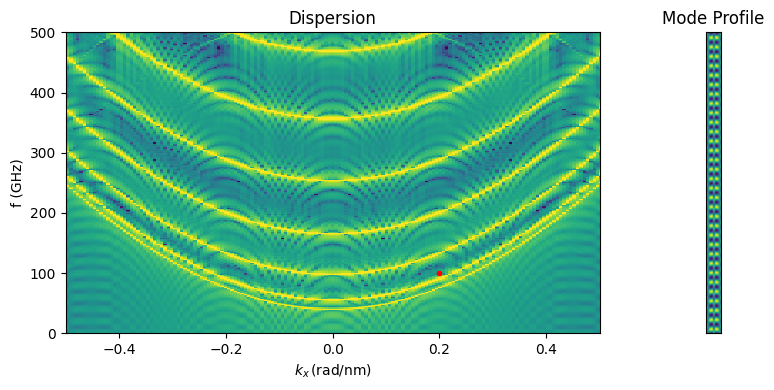

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

mt = torch.load("data/mt_saved.pt").cpu()
k = 0.2
f = 100

dt = 1e-12
n = 500, 25, 1
dx = 2e-9, 2e-9, 1e-9

# plot dispersion
mfft = torch.fft.fftn(mt, dim = (0,1))
ff = torch.fft.fftfreq(mfft.shape[0], dt)
kk = torch.fft.fftfreq(mfft.shape[1], dx[0])*2*torch.pi

disp = mfft[:,:,int(n[1]//2),0].abs()
cbmax_bv = 10.*np.log10(disp**2).max()
cbmin_bv = 10.*np.log10(disp**2).min()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 4])
ax1.set_title('Dispersion')
ax1.pcolormesh(torch.fft.fftshift(kk)/1e9, torch.fft.fftshift(ff)/1e9, 10.*np.log(torch.fft.fftshift(disp)**2.), vmin = cbmin_bv, vmax = cbmax_bv, cmap = "viridis", shading = "auto")
dot, = ax1.plot(k, f, 'r.')
ax1.set_xlabel(r'$k_{x}\,\mathrm{(rad/nm)}$', fontsize=10)
ax1.set_ylabel('f (GHz)', fontsize=10)
ax1.set_ylim([0, 500])
ax1.set_xlim([-0.5, 0.5])

# plot mode profile
def get_mi(f,k):
    # Determine ki and fi indizes
    fi = (ff-f*1e9).abs().argmin()
    ki = (kk-k*1e9).abs().argmin()

    mfft_i = torch.zeros_like(mfft[fi,...])
    mfft_i[ki,...] = mfft[fi,ki,...]
    mi = torch.fft.ifftn(mfft_i, dim = 0)
    return mi[:,:,0].real

mi = get_mi(f,k)
mi = mi / mi.max()

ax2.set_title('Mode Profile')
mode = ax2.imshow(mi)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

fig.canvas.header_visible = False
fig.canvas.footer_visible = False

fig.tight_layout()
fig.savefig("data/result.png")